In [ ]:
import numba
import numpy as np
import galsim
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook
sns.set()

SCALE = 0.25

We define two equal sized objects on the left and the right of the image.

In [ ]:
obj = [galsim.Gaussian(fwhm=4).shift(-16, 0), galsim.Gaussian(fwhm=4).shift(16, 0)]

In [ ]:
im = galsim.Sum(obj).drawImage(scale=SCALE, nx=320, ny=320)

plt.figure()
plt.imshow(im.array)
plt.gca().grid(False)

Here is what they look like with the variable PSF above.

In [ ]:
pobj = [
    galsim.Convolve(obj[0], galsim.Gaussian(fwhm=0.95)),
    galsim.Convolve(obj[1], galsim.Gaussian(fwhm=1.0))]

In [ ]:
im = galsim.Sum(pobj).drawImage(scale=SCALE, nx=320, ny=320)

plt.figure()
plt.imshow(im.array)
plt.gca().grid(False)

This function gets the target kernel

In [ ]:
if False:
    nr = 111
    nk = 7
    sz = (nr - nk) // 2

    gsp = galsim.GSParams(kvalue_accuracy=1e-300)
    gs2 = galsim.Gaussian(fwhm=1)
    gs1 = galsim.Gaussian(fwhm=0.95)

    base_k = galsim.Convolve(gs2, galsim.Deconvolve(gs1, gsparams=gsp)).drawImage(
            nx=nr, ny=nr, scale=SCALE, method='no_pixel')
    base_k = base_k.array[sz:-sz, sz:-sz]
    base_k = base_k / np.sum(base_k)

    ident_k = galsim.Convolve(gs2, galsim.Deconvolve(gs2, gsparams=gsp)).drawImage(
        nx=nr, ny=nr, scale=SCALE, method='no_pixel')
    ident_k = ident_k.array[sz:-sz, sz:-sz]
    ident_k = ident_k / np.sum(ident_k)
else:
    import scipy.fftpack
    nr = 33
    nk = 7
    sz = (nr - nk) // 2
    
    gs2 = galsim.Gaussian(fwhm=1).drawImage(nx=nr, ny=nr, scale=SCALE).array
    gs1 = galsim.Gaussian(fwhm=0.95).drawImage(nx=nr, ny=nr, scale=SCALE).array
    fgs2 = scipy.fftpack.fft2(gs2)
    fgs1 = scipy.fftpack.fft2(gs1)
    
    k = scipy.fftpack.fftshift(scipy.fftpack.ifft2(fgs2/fgs1).real)
    k = k[sz:-sz, sz:-sz]
    base_k = k / np.sum(k)
    
    base_k = _build_kernel(0.95)
    base_k = base_k / np.sum(base_k)    

    k = scipy.fftpack.fftshift(scipy.fftpack.ifft2(fgs2/fgs2).real)
    k = k[sz:-sz, sz:-sz]
    ident_k = k / np.sum(k)
    

def target_kernel(x, y):
    if x >= 320/2:
        return ident_k
    else:
        return base_k

In [ ]:
k20 = target_kernel(20, 0)
k60 = target_kernel(200, 0)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
ax = axs[0]
ax.imshow(k20)
ax.grid(False)

ax = axs[1]
ax.imshow(k60)
ax.grid(False)


In [ ]:
import numba

@numba.jit
def _conv_kern_func(target_kernel, im):
    im_new = np.zeros_like(im)
    nk = target_kernel(0, 0).shape[0]
    dk = (nk-1) //2
    for i_new in range(im.shape[0]):
        for j_new in range(im.shape[1]):
            k = target_kernel(j_new, i_new)
            
            i_old_start = max(0, i_new-dk)
            j_old_start = max(0, j_new-dk)
            
            i_old_end = min(i_new + dk + 1, im.shape[0])
            j_old_end = min(j_new + dk + 1, im.shape[1])            

            i_kern_start = max(0, dk-i_new)
            j_kern_start = max(0, dk-j_new)

            n_i_kern = i_old_end - i_old_start
            n_j_kern = j_old_end - j_old_start
            
            _sum = 0.0
            for _i in range(n_i_kern):
                for _j in range(n_j_kern):
                    _sum += im[i_old_start + _i, j_old_start + _j] * k[i_kern_start + _i, j_kern_start + _j]
            im_new[i_new, j_new] = _sum
    return im_new


In [ ]:
im = galsim.Sum(pobj).drawImage(scale=SCALE, nx=320, ny=320).array
im_new = _conv_kern_func(target_kernel, im)

In [ ]:
ppobj = [
    galsim.Convolve(obj[0], galsim.Gaussian(fwhm=1)),
    galsim.Convolve(obj[1], galsim.Gaussian(fwhm=1))]

imt = galsim.Sum(ppobj).drawImage(scale=SCALE, nx=320, ny=320).array

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

ax = axs[0, 0]
ax.imshow(im)
ax.grid(False)
ax.set_title('old')

ax = axs[0, 1]
ax.imshow(im_new)
ax.grid(False)
ax.set_title('new')

ax = axs[1, 0]
sns.heatmap((im - imt) / imt.max(), square=True, ax=ax)
ax.grid(False)
ax.set_title('old - target')

ax = axs[1, 1]
sns.heatmap((im_new - imt) / imt.max(), square=True, ax=ax)
ax.grid(False)
ax.set_title('new - target')


plt.tight_layout()

In [ ]:
g = galsim.Gaussian(sigma=2)
gsp = galsim.GSParams(kvalue_accuracy=1.e-7)
f2 = galsim.Convolve(g, galsim.Deconvolve(g, gsparams=gsp))
im = np.abs(f2.drawKImage().array)

plt.figure()
plt.imshow(im)
print(im.max(), im.min())

plt.figure()
plt.imshow(f2.drawImage(nx=33, ny=33, scale=0.25, method='no_pixel').array)

plt.figure()
plt.imshow(np.abs(f2.drawKImage(nx=50, ny=50).array))

In [ ]:
import tensorflow as tf
import numpy as np
import galsim

import numba
import numpy as np
import galsim
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.fftpack

%matplotlib notebook

SCALE = 0.25

In [ ]:
class TFSolver(object):
    def __init__(self, tgt, nk, C=0):
        self.nr = tgt.shape[0]
        self.nk = nk
        self.C = C
        
        self.graph = tf.Graph()
        self.session = tf.Session(graph=self.graph)
        
        ident = np.zeros((self.nk, self.nk))
        sz = (self.nk - 1) // 2
        ident[sz, sz] = 1.0
        # ident = scipy.fftpack.fftshift(ident)
        ident = ident.reshape(self.nk, self.nk, 1, 1)
        
        with self.graph.as_default():
            kern = tf.get_variable(
                'kern%d' % self.nk, 
                # shape=[self.nk, self.nk, 1, 1],
                initializer=tf.constant(ident.astype(np.float64)), 
                dtype=tf.float64)
            target_psf = tf.constant(tgt.astype(np.float64))
    
            kern = kern / tf.reduce_sum(kern)
            in_psf = tf.placeholder(tf.float64, [self.nr, self.nr])
            out_psf = tf.nn.conv2d(
                tf.reshape(in_psf, [1, self.nr, self.nr, 1]),
                kern,
                [1, 1, 1, 1],
                "SAME")
            loss = (
                tf.reduce_mean(tf.pow(out_psf - target_psf, 2)) / np.power(tgt.max(), 2) + 
                self.C * tf.reduce_mean(tf.abs(kern)))

            train_step = tf.contrib.opt.ScipyOptimizerInterface(
                            loss,
                            method='L-BFGS-B',
                            options={
                                'maxiter': 5000, 
                                'gtol': 1e-32, 
                                'eps': 1e-32,
                                'ftol': 1e-32})
            init = tf.global_variables_initializer()
            
            self.session.run(init)
            self.kern = kern
            self.train_step = train_step
            self.loss = loss
            self.out_psf = out_psf
            self.in_psf = in_psf
        
    def solve(self, psf):
        self.train_step.minimize(self.session, feed_dict={self.in_psf: psf})
        l = self.session.run(self.loss, feed_dict={self.in_psf: gs1})
        arr = self.kern.eval(session=self.session)
        return arr[:, :, 0, 0]

In [ ]:
gs2 = galsim.Gaussian(fwhm=1).drawImage(nx=33, ny=33, scale=SCALE).array
gs1 = galsim.Gaussian(fwhm=0.96).drawImage(nx=33, ny=33, scale=SCALE).array

solver = TFSolver(gs2, 7, C=0)
arr = solver.solve(gs1)

In [ ]:
ops = solver.out_psf.eval(session=solver.session, feed_dict={solver.in_psf: gs2})[0, :, :, 0]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6, 6))

ax = axs[0, 0]
ax.grid(False)
ax.imshow(ops)
ax.set_title('output')

ax = axs[0, 1]
ax.grid(False)
ax.imshow(gs2)
ax.set_title('target')

ax = axs[1, 0]
sns.heatmap((ops - gs2)/gs2.max(), ax=ax, square=True)
ax.set_title('output - target')

ax = axs[1, 1]
ax.grid(False)
ax.imshow(arr)
ax.set_title('kernel')

plt.tight_layout()

In [1]:
import numpy as np
import galsim

import numba
import numpy as np
import galsim
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.fftpack

%matplotlib notebook

SCALE = 0.25

In [18]:
# some imports constants we need
import ngmix
from ngmix.observation import Observation
from ngmix.fitting import LMSimple, LMCoellip
from ngmix.bootstrap import EMRunner

def _build_kernel(in_scale):
    gs2 = galsim.Gaussian(fwhm=1/SCALE).drawImage(nx=33, ny=33, scale=1).array
    gs1 = galsim.Gaussian(fwhm=in_scale/SCALE).drawImage(nx=33, ny=33, scale=1).array

    jacob = ngmix.UnitJacobian(
        row=16.0,
        col=16.0)

    psf_obs = Observation(gs1, jacobian=jacob)

    if False:
        ngauss = 3
        ntry = 5
        em_pars = {'maxiter':1000, 'tol':1.0e-6}
        runner = EMRunner(psf_obs, 4, ngauss, em_pars)
        runner.go(ntry=ntry)

        pres = runner.get_fitter().get_result()
        psf_gmix_fit = runner.get_fitter().get_gmix()
    elif True:
        pfitter = LMCoellip(psf_obs, 2)
        guess = np.zeros(4 + 2*2) + 1e-3
        guess[4:] = guess[-2*2:] + 1
        pfitter.go(guess)
        psf_gmix_fit = pfitter.get_gmix()
    else:
        pfitter = LMSimple(psf_obs, 'gauss')
        guess = np.zeros(6) + 1e-3
        guess[4:] = guess[4:] + 1
        pfitter.go(guess)
        psf_gmix_fit = pfitter.get_gmix()

    psf_gmix_fit.set_flux(1.0)
    psf_obs.set_gmix(psf_gmix_fit)

    obs = Observation(gs2, jacobian=jacob, psf=psf_obs)
    fitter = LMSimple(obs, 'gauss')
    guess = np.zeros(6) + 1e-3
    guess[4:] += 1
    fitter.go(guess)

    res = fitter.get_result()

    gmix = ngmix.GMixModel(res['pars'], 'gauss')

    im = gmix.make_image([7, 7], jacobian=ngmix.UnitJacobian(row=3, col=3))
    
    return im
    

     singular covariance
    pars at singular: -5.25e-07  6.15e-06  -3.19e-06  -5.88e-07       1.7       1.7     -53.6      54.6 
     bad covariance matrix
     singular covariance
    pars at singular: 2.47e-06  1.62e-07  -1.36e-09   1.2e-06      3.21         1 
     singular covariance
    pars at singular: -5.78e-08  -5.74e-09  -4.59e-10  -4.59e-08      0.66      2.99  -0.000478         1 
     singular covariance
    pars at singular: -3.35e-07  -1.41e-06  0.000236  -5.79e-05  4.41e-06         1 


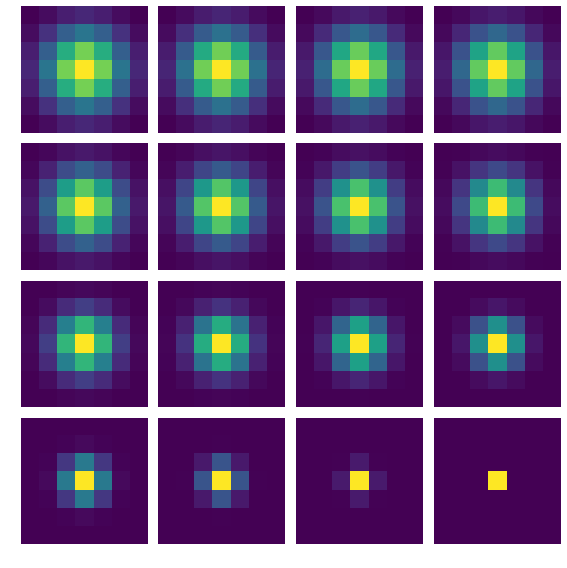

In [19]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(8, 8), sharex='all', sharey='all')

axs = axs.ravel()
scales = np.linspace(0.5, 1.0, 16)
for ax, scale in zip(axs, scales):
    im = _build_kernel(scale)
    ax.imshow(im)
    ax.grid(False)
    ax.axis('off')

plt.tight_layout()
plt.savefig('/Users/Matt/Desktop/kerns.png')